# SUSTAV ZA DETEKCIJU KARAKTERISTIČNIH TOČAKA LICA
Toni Polanec 2023.


In [1]:

import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import seaborn as sns
import cv2
import math
import json
import random
from sklearn.impute import SimpleImputer
from tqdm.keras import TqdmCallback
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU, BatchNormalization
from keras.initializers import glorot_uniform
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam


## Analiza podataka

In [2]:
# učitanje slika
face_images = np.load('face_images.npz')
faces=face_images.get(face_images.files[0]) 

# oblikovanje polja
faces=np.moveaxis(faces,-1,0)
faces=faces.reshape(faces.shape[0],faces.shape[1],faces.shape[1],1)

In [3]:
faces.shape

(7049, 96, 96, 1)

Ukupno imamo **7049** različitih slika.  
Svaka slika je veličine **96x96** piksela. 


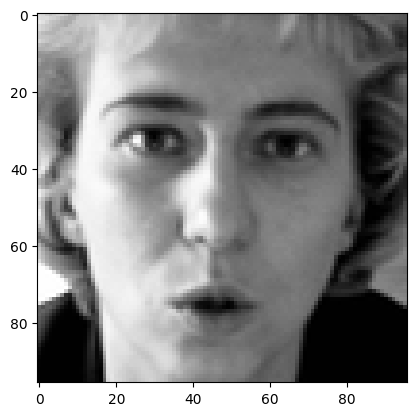

In [4]:
plt.imshow(faces[1], cmap='gray')

^ primjer slike

In [5]:
# čitanje datoteke s karakterističnim točkama lica
landmarks = pd.read_csv('facial_keypoints.csv')
landmarks.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166


Korišteni dataset ima sveukupno 15 karakterističnih točaka lica.  
U ovom radu koristit ćemo samo 9 točaka, i to:
- centar lijevog oka
- lijevi rub lijevog oka
- desni rub desnog oka

- centar desnog oka
- lijevi rub desnog oka
- desni rub desnog oka
  
- vrh nosa
  
- centar gornje usne
- centar donje usne

In [6]:
# brisanje podataka o obrvama i ustima (osim bottom_lip_center)
landmarks = landmarks.drop(['left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y', 'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x', 'mouth_right_corner_y'], axis=1)

In [7]:
landmarks.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,nose_tip_x,nose_tip_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,23.452872,37.389402,44.420571,57.066803,43.312602,72.935459,43.130707,84.485774
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,24.472511,33.144443,48.206298,55.660936,46.684596,70.266553,45.467915,85.480170
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,24.976421,36.603221,47.557263,53.538947,47.274947,70.191789,47.274947,78.659368
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,25.307270,38.007903,51.885078,54.166539,50.303165,70.091687,51.561183,78.268383
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,22.506110,38.305237,43.299534,64.889521,44.962748,73.707387,44.227141,86.871166


In [8]:
landmarks.shape

(7049, 18)

Za svaku sliku imamo 18 parametara koji predstavljaju koordinate 9 različitih točaka na licu (x,y).  
<br>
Zbog nepravilnosti dataseta moramo provjeriti koliko ima nepostojećih vrijednosti.

In [9]:
# provjera koliko null vrijednosti imamo u svakom stupcu
landmarks.isnull().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
nose_tip_x                      0
nose_tip_y                      0
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_bottom_lip_y      33
dtype: int64

Vidimo da ih ima dosta pa ćemo to sanirati u sljedećim koracima.

#### Prikaz tablice korelacije između karakterističnih točaka lica:

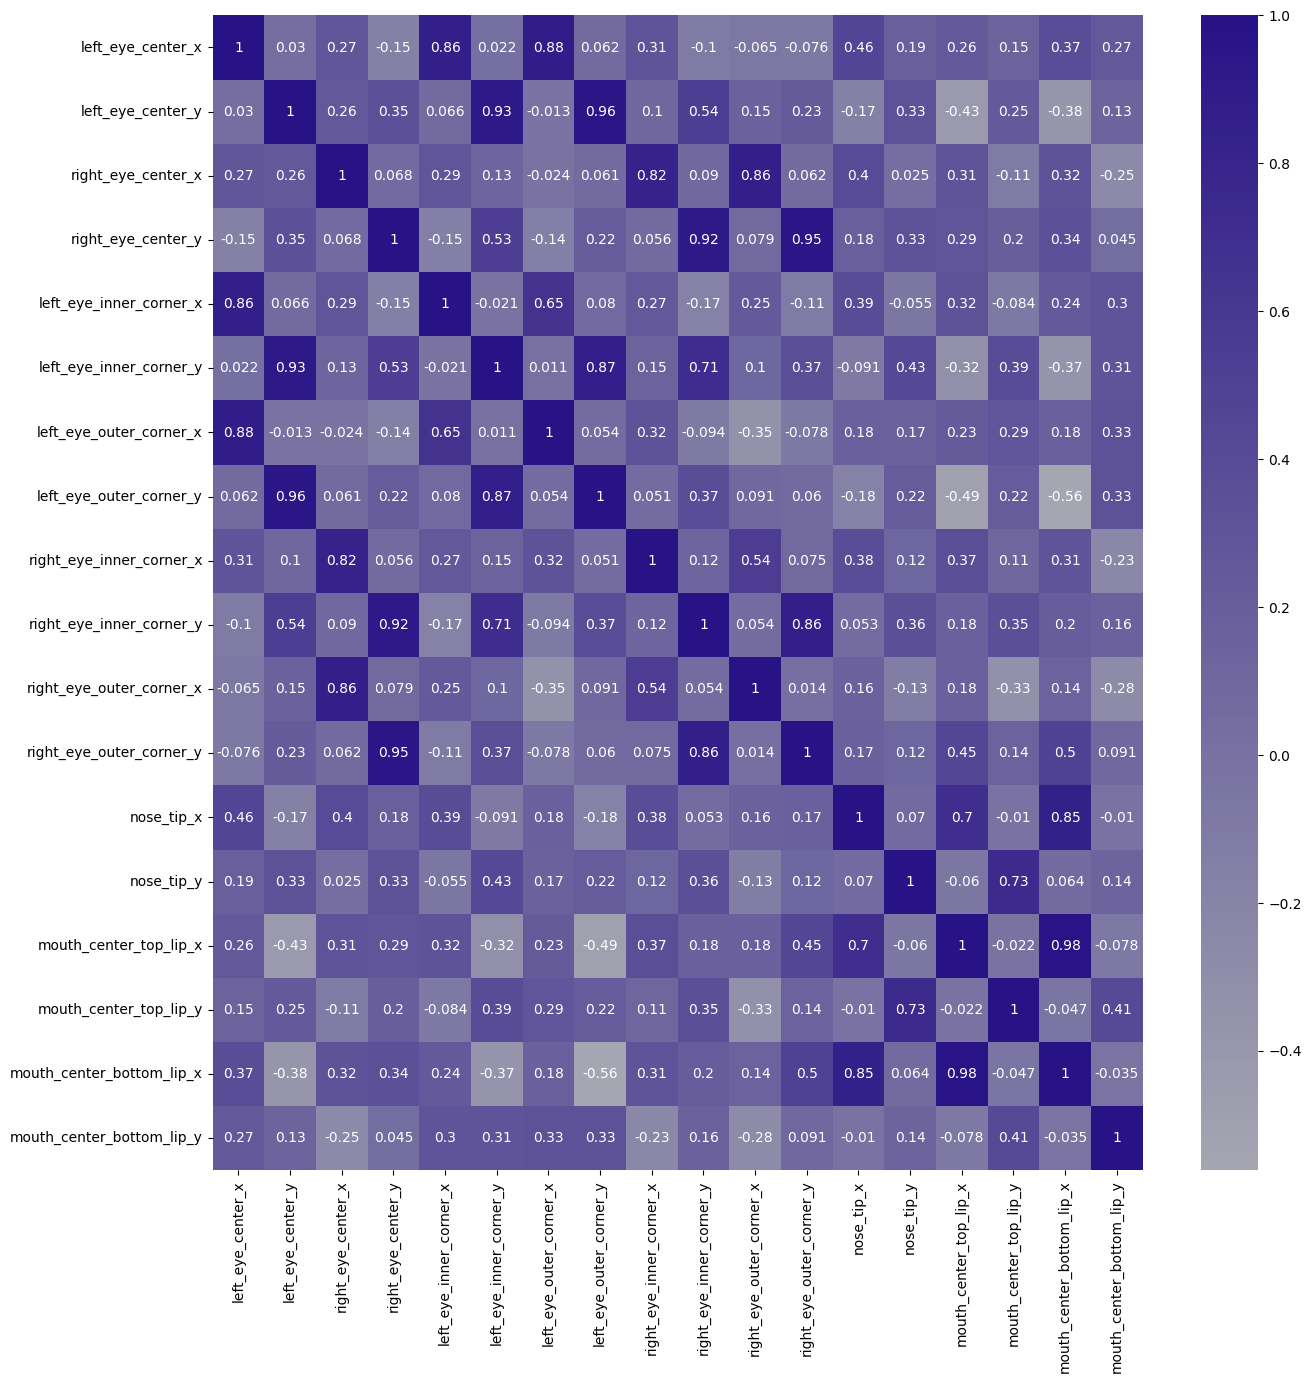

In [10]:
landmarks_correlation = landmarks.corr()

plt.figure(figsize=(15,15))
sns.heatmap(landmarks_correlation, cmap=sns.color_palette("blend:#A5A6B1,#271286", as_cmap=True), annot=True)
plt.show()


Po grafu iznad vidimo da imamo korelacije između nekih točaka u datasetu. Npr. *right_eye_center_x* i *right_eye_outer_corner_x* imaju korelaciju od 0.86.  
To ćemo iskoristiti da popunimo null vrijednosti u datasetu.  
<br>
Npr. uz pomoć točke centra oka ćemo izračunati točke vanjskog i unutarnjeg ruba oka.



## Predprocesiranje podataka

Po analizi podataka dobili smo informaciju da za karakterističnu točku *eye_center* fali samo 13 vrijednosti. Pa umijesto da izmišljam vrijednosti za te točke, odlučio sam ih izbaciti iz dataseta.



In [11]:
#! nekaj pokusavam dont mind me

null_rows = landmarks[['left_eye_inner_corner_x']].isnull().any(axis=1)
ind = 0
for r in null_rows:
    if r == True:
        print(ind)
    ind+=1

1654
1685
1738
1742
1866
1956
2036
2101
2137
2153
2175
2186
2227
2284
2285
2286
2287
2288
2289
2290
2291
2292
2293
2294
2295
2296
2297
2298
2299
2300
2301
2302
2303
2304
2305
2306
2307
2308
2309
2310
2311
2312
2313
2314
2315
2316
2317
2318
2319
2320
2321
2322
2323
2324
2325
2326
2327
2328
2329
2330
2331
2332
2333
2334
2335
2336
2337
2338
2339
2340
2341
2342
2343
2344
2345
2346
2347
2348
2349
2350
2351
2352
2353
2354
2355
2356
2357
2358
2359
2360
2361
2362
2363
2364
2365
2366
2367
2368
2369
2370
2371
2372
2373
2374
2375
2376
2377
2378
2379
2380
2381
2382
2383
2384
2385
2386
2387
2388
2389
2390
2391
2392
2393
2394
2395
2396
2397
2398
2399
2400
2401
2402
2403
2404
2405
2406
2407
2408
2409
2410
2411
2412
2413
2414
2415
2416
2417
2418
2419
2420
2421
2422
2423
2424
2425
2426
2427
2428
2429
2430
2431
2432
2433
2434
2435
2436
2437
2438
2439
2440
2441
2442
2443
2444
2445
2446
2447
2448
2449
2450
2451
2452
2453
2454
2455
2456
2457
2458
2459
2460
2461
2462
2463
2464
2465
2466
2467
2468
2469
2470


In [12]:
empty_rows = landmarks[['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y']].isnull().any(axis=1)
null_indexes = landmarks[empty_rows].index

# brisanje slika koje imaju te određene točke s null vrijednostima
faces = np.delete(faces, null_indexes, axis=0)
landmarks = landmarks.dropna(subset=['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y'], how='any')


print("landmarks.shape ->", landmarks.shape)
print("faces.shape ->", faces.shape)
# provjera koliko null vrijednosti imamo u svakom stupcu
landmarks.isnull().sum()




landmarks.shape -> (7033, 18)
faces.shape -> (7033, 96, 96, 1)


left_eye_center_x               0
left_eye_center_y               0
right_eye_center_x              0
right_eye_center_y              0
left_eye_inner_corner_x      4773
left_eye_inner_corner_y      4773
left_eye_outer_corner_x      4776
left_eye_outer_corner_y      4776
right_eye_inner_corner_x     4771
right_eye_inner_corner_y     4771
right_eye_outer_corner_x     4771
right_eye_outer_corner_y     4771
nose_tip_x                      0
nose_tip_y                      0
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_bottom_lip_y      33
dtype: int64

Isto tako za *mouth_center_bottom_lip* fali 33 vrijednosti, pa ćemo i njih izbaciti iz dataseta.


In [13]:
empty_rows = landmarks[['mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y']].isnull().any(axis=1)
null_indexes = landmarks[empty_rows].index

# brisanje slika koje imaju te određene točke s null vrijednostima
faces = np.delete(faces, null_indexes, axis=0)
landmarks = landmarks.dropna(subset=['mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y'], how='any')

print("landmarks.shape ->", landmarks.shape)
print("faces.shape ->", faces.shape)
# provjera koliko null vrijednosti imamo u svakom stupcu
landmarks.isnull().sum()

landmarks.shape -> (7000, 18)
faces.shape -> (7000, 96, 96, 1)


left_eye_center_x               0
left_eye_center_y               0
right_eye_center_x              0
right_eye_center_y              0
left_eye_inner_corner_x      4763
left_eye_inner_corner_y      4763
left_eye_outer_corner_x      4765
left_eye_outer_corner_y      4765
right_eye_inner_corner_x     4761
right_eye_inner_corner_y     4761
right_eye_outer_corner_x     4760
right_eye_outer_corner_y     4760
nose_tip_x                      0
nose_tip_y                      0
mouth_center_top_lip_x       4755
mouth_center_top_lip_y       4755
mouth_center_bottom_lip_x       0
mouth_center_bottom_lip_y       0
dtype: int64

### Popunjavanje null vrijednosti

In [14]:
# podjela na skup s null vrijednostima i skup bez null vrijednosti
landmarks_null = landmarks[landmarks.isnull().any(axis=1)]
landmarks_not_null = landmarks.dropna()

print(f"landmarks_null:{landmarks_null.shape}   landmarks_not_null:{landmarks_not_null.shape}")

landmarks_null:(4777, 18)   landmarks_not_null:(2223, 18)


Sad vidimo da imamo točku centra lijevog i desnog oka, pomoću tih koordinata izračunati ćemo koordinate točaka oko oka koje nedostaju.  
OČI:   *left_eye_inner_corner left_eye_outer_corner, right_eye_inner_corner right_eye_outer_corner*  

Isto tako za usta, imamo točku donjeg centra usne.  
USTA:  *mouth_center_top_lip*    



In [15]:
not_null_size = landmarks_not_null.shape[0]
print(f"not_null_size: {not_null_size}")

# EYES

left_eye_inner_corner_x_avg_diff = (landmarks_not_null['left_eye_inner_corner_x'].values - landmarks_not_null['left_eye_center_x'].values).sum() / not_null_size
left_eye_inner_corner_y_avg_diff = (landmarks_not_null['left_eye_inner_corner_y'].values - landmarks_not_null['left_eye_center_y'].values).sum() / not_null_size

left_eye_outer_corner_x_avg_diff = (landmarks_not_null['left_eye_outer_corner_x'].values - landmarks_not_null['left_eye_center_x'].values).sum() / not_null_size
left_eye_outer_corner_y_avg_diff = (landmarks_not_null['left_eye_outer_corner_y'].values - landmarks_not_null['left_eye_center_y'].values).sum() / not_null_size

right_eye_inner_corner_x_avg_diff = (landmarks_not_null['right_eye_inner_corner_x'].values - landmarks_not_null['right_eye_center_x'].values).sum() / not_null_size
right_eye_inner_corner_y_avg_diff = (landmarks_not_null['right_eye_inner_corner_y'].values - landmarks_not_null['right_eye_center_y'].values).sum() / not_null_size

right_eye_outer_corner_x_avg_diff = (landmarks_not_null['right_eye_outer_corner_x'].values - landmarks_not_null['right_eye_center_x'].values).sum() / not_null_size
right_eye_outer_corner_y_avg_diff = (landmarks_not_null['right_eye_outer_corner_y'].values - landmarks_not_null['right_eye_center_y'].values).sum() / not_null_size


# MOUTH

mouth_center_top_lip_x_avg_diff = (landmarks_not_null['mouth_center_top_lip_x'].values - landmarks_not_null['mouth_center_bottom_lip_x'].values).sum() / not_null_size
mouth_center_top_lip_y_avg_diff = (landmarks_not_null['mouth_center_top_lip_y'].values - landmarks_not_null['mouth_center_bottom_lip_y'].values).sum() / not_null_size


print("\nRavnamo se po 'Left eye center':\n" +
    f"left_eye_inner_corner_x_avg_diff:\t{left_eye_inner_corner_x_avg_diff}\n" +
    f"left_eye_inner_corner_y_avg_diff:\t{left_eye_inner_corner_y_avg_diff}\n" +
    f"left_eye_outer_corner_x_avg_diff:\t{left_eye_outer_corner_x_avg_diff}\n" +
    f"left_eye_outer_corner_y_avg_diff:\t{left_eye_outer_corner_y_avg_diff}\n" +
    "\nRavnamo se po 'Right eye center':\n" +
    f"right_eye_inner_corner_x_avg_diff:\t{right_eye_inner_corner_x_avg_diff}\n" +
    f"right_eye_inner_corner_y_avg_diff:\t{right_eye_inner_corner_y_avg_diff}\n" +
    f"right_eye_outer_corner_x_avg_diff:\t{right_eye_outer_corner_x_avg_diff}\n" +
    f"right_eye_outer_corner_y_avg_diff:\t{right_eye_outer_corner_y_avg_diff}\n" +
    
    "\nRavnamo se po 'Mouth center bottom lip':\n" +
    f"mouth_center_top_lip_x_avg_diff:\t{mouth_center_top_lip_x_avg_diff}\n" +
    f"mouth_center_top_lip_y_avg_diff:\t{mouth_center_top_lip_y_avg_diff}\n"
    )


not_null_size: 2223

Ravnamo se po 'Left eye center':
left_eye_inner_corner_x_avg_diff:	-6.959310901867835
left_eye_inner_corner_y_avg_diff:	1.0200772757839405
left_eye_outer_corner_x_avg_diff:	7.206602055885921
left_eye_outer_corner_y_avg_diff:	0.7929320375488079

Ravnamo se po 'Right eye center':
right_eye_inner_corner_x_avg_diff:	6.978360061369726
right_eye_inner_corner_y_avg_diff:	0.8757421367244264
right_eye_outer_corner_x_avg_diff:	-7.29579624399982
right_eye_outer_corner_y_avg_diff:	0.9593579376828159

Ravnamo se po 'Mouth center bottom lip':
mouth_center_top_lip_x_avg_diff:	-0.07053680240256414
mouth_center_top_lip_y_avg_diff:	-9.678928373382005



Sad imamo prosječne udaljenosti od poznatih točaka.  
Možemo popuniti sve null vrijednosti tako da dodamo ili oduzmemo prosječnu udaljenost od poznate točke.

In [16]:
# EYES
landmarks['left_eye_inner_corner_x'] = landmarks['left_eye_inner_corner_x'].fillna(landmarks['left_eye_center_x'] + left_eye_inner_corner_x_avg_diff)
landmarks['left_eye_inner_corner_y'] = landmarks['left_eye_inner_corner_y'].fillna(landmarks['left_eye_center_y'] + left_eye_inner_corner_y_avg_diff)

landmarks['left_eye_outer_corner_x'] = landmarks['left_eye_outer_corner_x'].fillna(landmarks['left_eye_center_x'] + left_eye_outer_corner_x_avg_diff)
landmarks['left_eye_outer_corner_y'] = landmarks['left_eye_outer_corner_y'].fillna(landmarks['left_eye_center_y'] + left_eye_outer_corner_y_avg_diff)

landmarks['right_eye_inner_corner_x'] = landmarks['right_eye_inner_corner_x'].fillna(landmarks['right_eye_center_x'] + right_eye_inner_corner_x_avg_diff)
landmarks['right_eye_inner_corner_y'] = landmarks['right_eye_inner_corner_y'].fillna(landmarks['right_eye_center_y'] + right_eye_inner_corner_y_avg_diff)

landmarks['right_eye_outer_corner_x'] = landmarks['right_eye_outer_corner_x'].fillna(landmarks['right_eye_center_x'] + right_eye_outer_corner_x_avg_diff)
landmarks['right_eye_outer_corner_y'] = landmarks['right_eye_outer_corner_y'].fillna(landmarks['right_eye_center_y'] + right_eye_outer_corner_y_avg_diff)

# MOUTH
landmarks['mouth_center_top_lip_x'] = landmarks['mouth_center_top_lip_x'].fillna(landmarks['mouth_center_bottom_lip_x'] + mouth_center_top_lip_x_avg_diff)
landmarks['mouth_center_top_lip_y'] = landmarks['mouth_center_top_lip_y'].fillna(landmarks['mouth_center_bottom_lip_y'] + mouth_center_top_lip_y_avg_diff)

# Provjera ako sad još uvijek ima null vrijednosti
landmarks.isnull().sum()

left_eye_center_x            0
left_eye_center_y            0
right_eye_center_x           0
right_eye_center_y           0
left_eye_inner_corner_x      0
left_eye_inner_corner_y      0
left_eye_outer_corner_x      0
left_eye_outer_corner_y      0
right_eye_inner_corner_x     0
right_eye_inner_corner_y     0
right_eye_outer_corner_x     0
right_eye_outer_corner_y     0
nose_tip_x                   0
nose_tip_y                   0
mouth_center_top_lip_x       0
mouth_center_top_lip_y       0
mouth_center_bottom_lip_x    0
mouth_center_bottom_lip_y    0
dtype: int64

### Vizualizacija podataka

In [17]:
# https://www.kaggle.com/code/satyaprakash13820/facial-landmark?scriptVersionId=76260280&cellId=13


print(f"faces.shape -> {faces.shape}")
landmark_len = len(landmarks)
print(f"key_feature_num -> {landmark_len}\n")

normalized_faces = faces
normalized_faces = normalized_faces/255 # Normalizacija

landmarks.reset_index(drop=True, inplace=True)

print(f"normalized_faces.shape -> {normalized_faces.shape}")
print(normalized_faces)



faces.shape -> (7000, 96, 96, 1)
key_feature_num -> 7000

normalized_faces.shape -> (7000, 96, 96, 1)
[[[[0.93333333]
   [0.9254902 ]
   [0.92941176]
   ...
   [0.98039216]
   [0.98039216]
   [0.98039216]]

  [[0.92156863]
   [0.93333333]
   [0.9254902 ]
   ...
   [0.97647059]
   [0.98039216]
   [0.98431373]]

  [[0.92941176]
   [0.9254902 ]
   [0.92941176]
   ...
   [0.98431373]
   [0.98431373]
   [0.98039216]]

  ...

  [[0.72941176]
   [0.71764706]
   [0.70980392]
   ...
   [0.20392157]
   [0.22352941]
   [0.23529412]]

  [[0.74117647]
   [0.7372549 ]
   [0.81176471]
   ...
   [0.23921569]
   [0.27058824]
   [0.30588235]]

  [[0.74901961]
   [0.72156863]
   [0.72156863]
   ...
   [0.2745098 ]
   [0.29411765]
   [0.35294118]]]


 [[[0.85882353]
   [0.84313725]
   [0.8       ]
   ...
   [0.36078431]
   [0.34509804]
   [0.32941176]]

  [[0.87058824]
   [0.85882353]
   [0.8627451 ]
   ...
   [0.36078431]
   [0.34509804]
   [0.3372549 ]]

  [[0.90588235]
   [0.87843137]
   [0.83137255]
 

In [18]:
def plot_image(image_array, landmarks, index):
    plt.imshow(image_array[index], cmap='gray')
    plt.scatter(landmarks.iloc[index,0::2], landmarks.iloc[index,1::2], c="#0f0", marker='P')
    plt.yticks([])
    plt.xticks([])
    print(index)
    plt.show()

6165


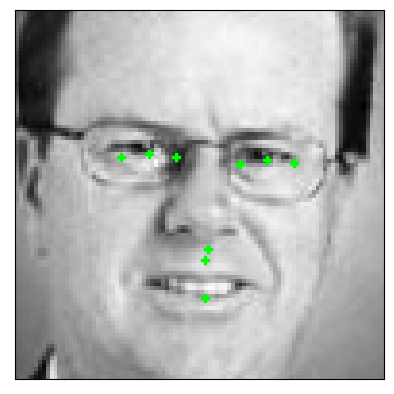

In [19]:
plot_image(normalized_faces, landmarks, random.randint(3000,7000))

5699


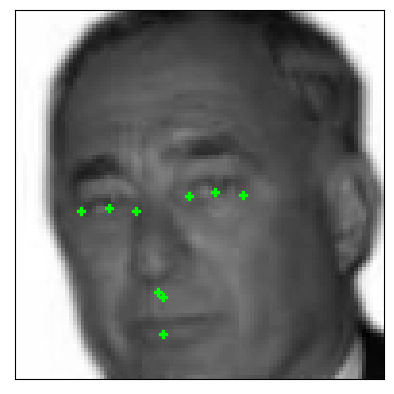

In [20]:
plot_image(normalized_faces, landmarks, 5699)

Neke točke nisu najpreciznije označene, ali to je nedostatak izračunavanja nedostajućih vrijednosti u datasetu i sa tim ćemo morati živjeti.

In [21]:
def plot_mult_images(image_array, landmarks, rows = 3, cols = 3):
    default_pics = [random.randint(3000,7000) for i in range(rows*cols)]
    pic_size = 96
    index = 0

    fig, ax = plt.subplots(rows,cols,sharex=True,sharey=True,figsize=[cols*2,rows*2])
    for row in range(rows):
        for col in range(cols):
            ax[row,col].imshow(image_array[default_pics[index]], cmap='gray')
            ax[row,col].scatter(landmarks.iloc[default_pics[index],0::2], landmarks.iloc[default_pics[index],1::2], c="#0f0", marker='+')
            ax[row,col].set_xticks(())
            ax[row,col].set_yticks(())
            ax[row,col].set_title('image index = %d' %(default_pics[index]),fontsize=10)
            index += 1

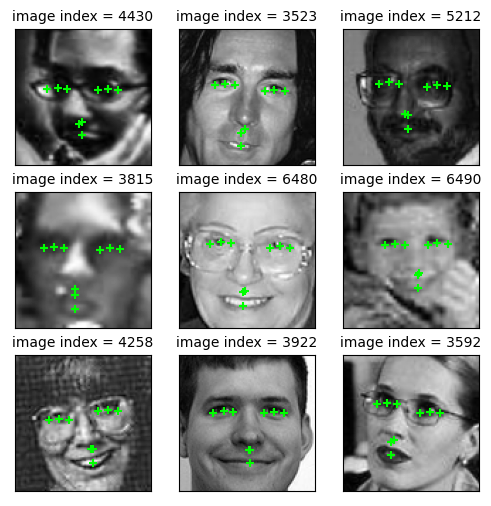

In [22]:
plot_mult_images(normalized_faces, landmarks)

## Model

Priprema podataka za treniranje modela.

In [23]:
train_x,test_x,train_y,test_y=train_test_split(normalized_faces, landmarks, test_size=0.2, random_state=42)

print(f"train_x.shape -> {train_x.shape}")
print(f"train_y.shape -> {train_y.shape}")
print(f"test_x.shape  -> {test_x.shape}")
print(f"test_y.shape  -> {test_y.shape}")



train_x.shape -> (5600, 96, 96, 1)
train_y.shape -> (5600, 18)
test_x.shape  -> (1400, 96, 96, 1)
test_y.shape  -> (1400, 18)


In [24]:
# Use Sequential Layer and Batch Normalisation layer
img_size=96
model=Sequential()

model.add(Input(shape=(img_size, img_size, 1)))

model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding="same", kernel_initializer=glorot_uniform(), activation=LeakyReLU(0.1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding="same", kernel_initializer=glorot_uniform(), activation=LeakyReLU(0.1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding="same", kernel_initializer=glorot_uniform(), activation=LeakyReLU(0.1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256, kernel_initializer=glorot_uniform(), activation=LeakyReLU(0.1)))
model.add(Dropout(0.5))
model.add(Dense(64, kernel_initializer=glorot_uniform(), activation=LeakyReLU(0.1)))

model.add(Dense(18,kernel_initializer=glorot_uniform()))

In [25]:
model.summary()                      

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 96, 96, 1)        4         
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 48, 48, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                        

In [26]:
# model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['mean_squared_error'])

model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=7.1361e-06), metrics=['mean_squared_error'])


### Model visualisation

In [27]:
import visualkeras

visualkeras.layered_view(model, to_file='model_300epochs_128batch_visualisation.png', legend=True).show() # write and show

KeyboardInterrupt: 

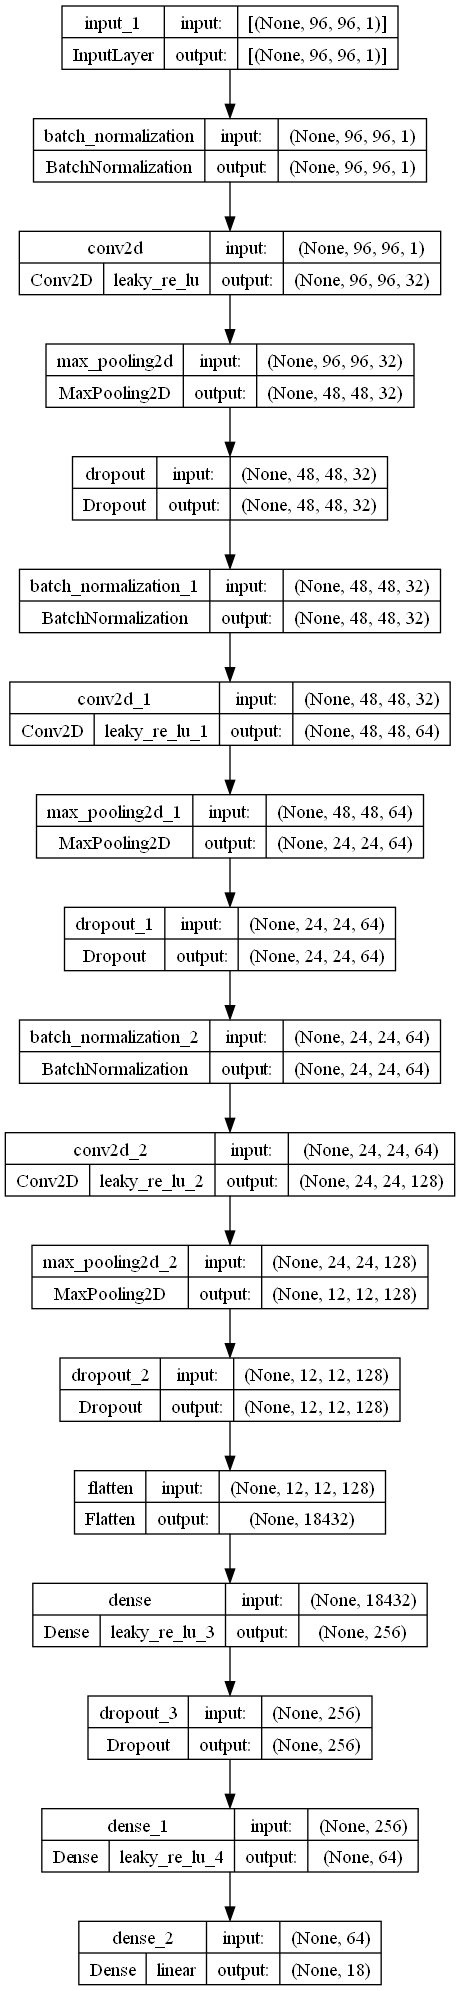

In [28]:
import graphviz
import pydot

tf.keras.utils.plot_model(
    model,
    to_file="model_300_128_visualisation2.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True)

In [551]:
from ann_visualizer.visualize import ann_viz

ann_viz(model, 
    view=True, 
    filename="model_300_128_visualisation3.png", 
    title="Model visualisation")

ValueError: ANN Visualizer: Layer not supported for visualizing

In [537]:
batch_size = 128
epochs = 300

# history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, validation_data=(test_x, test_y), shuffle=True, verbose=1)

def learing_rate_changer(epoch, lr):
    if epoch < 0.9*epochs:
        return lr
    else:
        return lr * tf.math.exp(-0.09)

    
callback = tf.keras.callbacks.LearningRateScheduler(learing_rate_changer)

history = model.fit(
    train_x, train_y,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (test_x, test_y),
    callbacks = [callback])




model.save('model_temp.h5')
history_dict = model.history
json.dump(history_dict, open('model_history_temp.json', 'w'))

tf.Tensor(4.3830804e-07, shape=(), dtype=float32)
Epoch 1/300
 7/44 [===>..........................] - ETA: 41s - loss: 26.1574 - mean_squared_error: 26.1574

KeyboardInterrupt: 

In [ ]:
#model.save('model.h5')

---

In [28]:
model = load_model('model_300epochs_128batch.h5')

---

Možemo prikazati graf smanjenja greške predikcije kroz epohe.  

In [536]:

# history_dict = json.load(open('model_history_temp.json', 'r'))

plt.plot(history.history['mean_squared_error'])
plt.title('Mean squared error')
plt.ylabel('mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

In [29]:
y_pred = model.predict(test_x)

44/44 [==============================] - 3s 59ms/step


In [30]:
def plot_predicted_image(images, truth, prediction, index):
    print(index, "->" , prediction[index])
    plt.imshow(images[index], cmap='gray')
    plt.scatter(truth.iloc[index, 0::2], truth.iloc[index, 1::2], c="#0f0", marker='P')
    plt.scatter(prediction[index, 0::2], prediction[index, 1::2], c="#f00", marker='P')
    plt.legend(["Truth","Prediction"])
    plt.show()

Usporedimo predicted sliku s originalnom slikom.


10 -> [62.044937 33.82103  26.784967 34.158253 54.970932 34.03558  67.434715
 34.180885 33.730053 34.537037 21.00972  34.49009  43.7318   56.12724
 44.46326  66.82806  43.6191   76.03311 ]


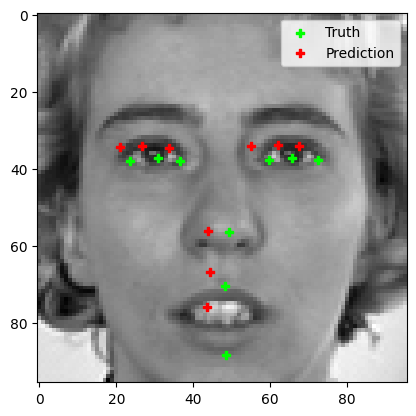

In [31]:
plot_predicted_image(test_x, test_y, y_pred, 10)

In [535]:
def plot_predicted_images(images, truth, prediction, indexes = [1258, 883, 420, 989, 73, 277, 648, 776, 184]):
    rows = 3
    cols = 3

    arr_i = 0
    fig, ax = plt.subplots(rows,cols,sharex=True,sharey=True,figsize=[cols*2,rows*2])
    for row in range(rows):
        for col in range(cols):
            index = indexes[arr_i]
            ax[row,col].imshow(images[index], cmap='gray')
            ax[row,col].scatter(truth.iloc[index, 0::2], truth.iloc[index, 1::2], c="#0f0", marker='+')
            ax[row,col].scatter(prediction[index, 0::2], prediction[index, 1::2], c="#f00", marker='+')
            # ax[row,col].set_xticks(())
            # ax[row,col].set_yticks(())
            ax[row,col].set_title('image index = %d' %(index),fontsize=10)
            arr_i += 1

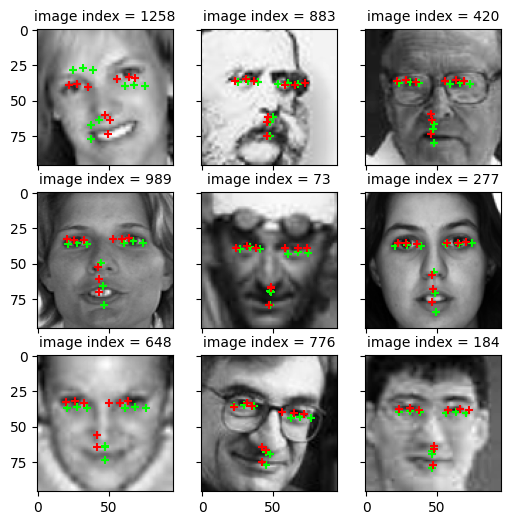

In [64]:
random_indexes = [random.randint(0, len(test_x))-1 for i in range(9)]
plot_predicted_images(test_x, test_y, y_pred, random_indexes)

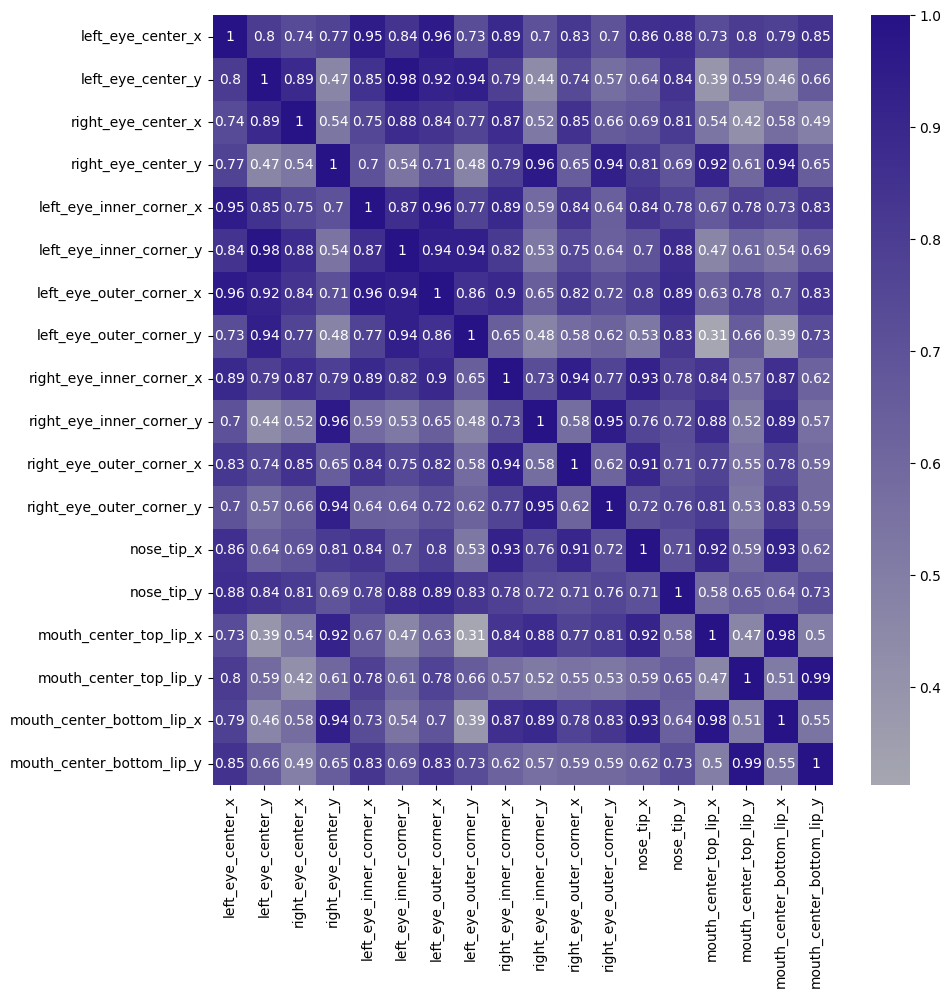

In [526]:
landmarks_trained = pd.DataFrame(y_pred, columns=landmarks.columns)
landmarks_trained.head()
plt.figure(figsize=(10,10))
sns.heatmap(landmarks_trained.corr(), cmap=sns.color_palette("blend:#A5A6B1,#271286", as_cmap=True), annot=True)
plt.show()

In [528]:
landmarks_trained.describe().T

,count,mean,std,min,25%,50%,75%,max
left_eye_center_x,1400.0,64.266296,3.282722,50.542801,61.997242,64.554562,66.553507,73.390106
left_eye_center_y,1400.0,35.964546,2.010196,28.254887,34.559292,35.975994,37.396192,41.928558
right_eye_center_x,1400.0,28.986231,1.712819,23.294903,27.818884,29.008914,30.197232,33.997860
right_eye_center_y,1400.0,35.359879,2.035968,29.323626,34.051756,35.359840,36.727115,41.519211
left_eye_inner_corner_x,1400.0,56.523186,2.828660,44.694374,54.723602,56.598976,58.382283,65.519829
left_eye_inner_corner_y,1400.0,36.553383,1.980882,28.917217,35.168900,36.574165,37.906438,42.206055
left_eye_outer_corner_x,1400.0,70.003441,3.348116,56.280060,67.750078,70.169357,72.275833,79.793823
left_eye_outer_corner_y,1400.0,36.230576,2.128948,28.499311,34.692784,36.242241,37.660191,43.032677
right_eye_inner_corner_x,1400.0,35.453827,1.830509,28.276915,34.308237,35.530859,36.692003,40.583008
right_eye_inner_corner_y,1400.0,36.665176,2.367041,29.845316,35.078041,36.656828,38.245987,43.547279


In [530]:
landmarks.describe().T

,count,mean,std,min,25%,50%,75%,max
left_eye_center_x,7000.0,66.349400,3.377149,22.763345,65.082412,66.490445,68.019111,94.689280
left_eye_center_y,7000.0,37.618104,3.036592,1.616512,35.897951,37.521582,39.240560,80.502649
right_eye_center_x,7000.0,30.303407,2.948946,0.686592,28.788607,30.252292,31.766950,85.039381
right_eye_center_y,7000.0,37.942656,2.884111,4.091264,36.326021,37.807311,39.555408,81.270911
left_eye_inner_corner_x,7000.0,59.390861,3.332490,19.064954,58.137174,59.583230,61.062075,87.729969
left_eye_inner_corner_y,7000.0,38.638887,2.972883,2.636589,36.961116,38.534312,40.195888,81.522726
left_eye_outer_corner_x,7000.0,73.556339,3.528861,27.571879,72.109158,73.726033,75.393558,101.895882
left_eye_outer_corner_y,7000.0,38.411014,3.140794,2.409444,36.632053,38.348822,40.152482,81.295581
right_eye_inner_corner_x,7000.0,37.282284,2.910519,5.751046,35.828646,37.220591,38.704598,92.017741
right_eye_inner_corner_y,7000.0,38.819977,2.822642,4.967006,37.222652,38.678036,40.369974,82.146653


In [531]:
for i in landmarks.columns:
    index = 0
    for l in landmarks[i]:
        if l < 0 or l > 96:
            print(i, l)
            print(index)
        index += 1
            


left_eye_outer_corner_x 101.89588205588592
4217
right_eye_outer_corner_x -5.767268977379819
1884
right_eye_outer_corner_x -6.6092042439998195
3602
right_eye_outer_corner_x -1.9015562439998197
6224
right_eye_outer_corner_x -3.62356491869982
6268


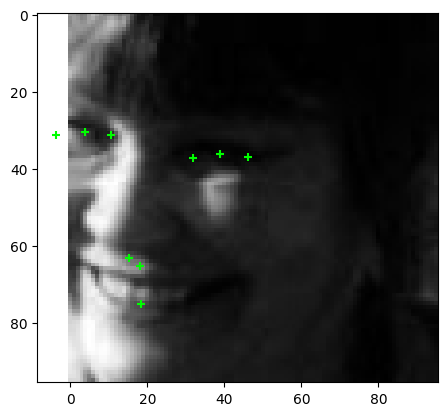

In [532]:
ind = 6268
plt.imshow(normalized_faces[ind], cmap='gray')
plt.scatter(landmarks.iloc[ind,0::2], landmarks.iloc[ind,1::2], c="#0f0", marker='+')
plt.show()

left_eye_center_x            66.033564
right_eye_center_x           30.227008
left_eye_inner_corner_x      59.582075
left_eye_outer_corner_x      73.130346
right_eye_inner_corner_x     36.356571
right_eye_outer_corner_x     23.452872
nose_tip_x                   44.420571
mouth_center_top_lip_x       43.312602
mouth_center_bottom_lip_x    43.130707
Name: 0, dtype: float64


InvalidIndexError: (array([59.168457, 31.87991 , 26.385157, 31.507824, 50.862934, 32.73086 ,
       63.517536, 31.628374, 32.025696, 32.847588, 20.007177, 32.180016,
       40.77549 , 55.347637, 41.131832, 58.829426, 41.29234 , 67.58701 ],
      dtype=float32), slice(0, None, 2))

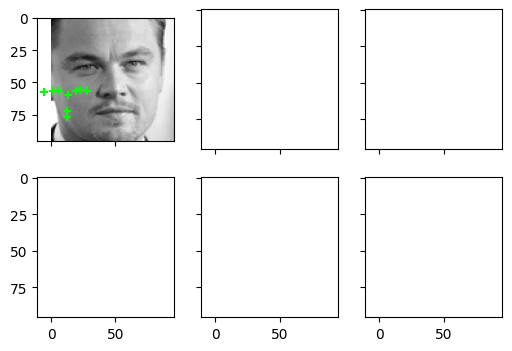

In [533]:
default_pics = [1884, 3602, 4217, 6224, 6268]
pic_size = 96
index = 0
rows = 2
cols = 3
fig, ax = plt.subplots(rows,cols,sharex=True,sharey=True,figsize=[cols*2,rows*2])
for row in range(rows):
    for col in range(cols):
        if row == 1 and col == 2:
            break
        ax[row,col].imshow(normalized_faces[default_pics[index]], cmap='gray')
        print(landmarks.iloc[index,0::2])
        ax[row,col].scatter(landmarks.iloc[default_pics[index], 0::2], landmarks.iloc[default_pics[index], 1::2], c="#0f0", marker='+')
        ax[row,col].scatter(landmarks_trained[y_pred[index], 0::2], y_pred[default_pics[index], 1::2], c="#f00", marker='+')
        ax[row,col].set_title('image index = %d' %(default_pics[index]),fontsize=10)
        index += 1